# Data Scientist Professional DS601P Practical Exam Submission

This DataCamp datalab (Jupyter-style) notebook and its rendered report (together, this **Report**) form part of the my deliverables for Practical Exam DS601P (this **Project**) as part of the DataCamp Data Scientist in R certification. This Report accompanies a video recorded presentation of the my findings. I undertook this Project according to the [DS601P Project Instructions](https://s3.amazonaws.com/talent-assets.datacamp.com/Practical+-+DSP+-+Recipe+Site+Traffic+-+2212.pdf).

# Introduction

This Report presents an end-to-end analysis aimed at addressing a key business challenge for Tasty Bytes: predicting which recipes will drive high website traffic when featured on the homepage.The product team has observed that selecting popular recipes can increase overall site engagement by up to 40%, directly impacting subscription growth. Using the provided dataset, this Report includes data validation, exploratory insights, and predictive modeling to estimate recipe popularity. The goal is to develop actionable recommendations and define a monitoring metric that aligns with the company’s objective of improving homepage recipe selection and maximizing user engagement.

- I wrote the code using `snake_case` and attempted to follow the guidance of the online resource [*R for Data Science (2e)*](https://r4ds.hadley.nz/) by Wickham, Çetinkaya-Rundel, and Grolemund.
- I adopted the [*Tidyverse Style Guide*](https://style.tidyverse.org/) with a preference toward piping operations where possible for code clarity.
- I used the native pipe where possible and fall back to the [*magrittr*](https://magrittr.tidyverse.org/) pipe where necessary.
- I also used the [*viridis*](https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html), colourising charts to improve accessibility of visualisations for readers with colour vision deficiency.
- I opted for the [Tidymodels](https://www.tidymodels.org/) ecosystem for my analysis, as it promotes good modelling practices by streamlining workflows, minimizing data leakage risks, and ensuring reproducibility.
- I followed the modelling process from [Tidy Modeling with R](https://www.tmwr.org/).

## Environment Setup

I started by setting a random seed to make sure my results were reproducible. Then I loaded the key packages I needed for this workflow. The `tidyverse` gave me tools for data wrangling and visualisation, while `viridis` provided colour palettes that were accessible for users with vision differences. I used the `conflicted` package to handle function name clashes, explicitly preferring the `dplyr` versions of `filter()` and `lag()`. Finally, I loaded `tidymodels` for modelling tasks and called `tidymodels_prefer()` to ensure consistent function choices within the modelling framework.

In [1]:
set.seed(1)
library(tidyverse)
library(ggrepel)
library(viridis)
library(conflicted)
conflict_prefer("filter", "dplyr")
conflict_prefer("lag", "dplyr")
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite

[conflicted] Will prefer dplyr::filter over any other package.
[conflicted] Will prefer dplyr::lag over any other package.
── Attaching packages ────────────────────────────────────── tidymodels 1.3.0 ──

✔ broom        1.0.8     ✔ rsample      1.3.0
✔ dials        1.4.0     ✔ tune         1.3.0
✔ infer        1.0.8     ✔ workflows    1.2.0
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.3.1     ✔ yardstick    1.3.2
✔ 

## Data Import

I imported the dataset from the CSV file using `read.csv()` and stored it in an object called `recipe_site_traffic_2212`. Then I used the native R pipe operator `|>` to pass the data to `glimpse()`, which gave me a quick overview of the dataset’s structure and variable types.

In [2]:
require(tidyverse)
traffic <- 
    read_csv(
        'recipe_site_traffic_2212.csv',
        show_col_types = FALSE)
traffic |> glimpse()

Rows: 947
Columns: 8
$ recipe       <chr> "001", "002", "003", "004", "005", "006", "007", "008", "…
$ calories     <dbl> NA, 35.48, 914.28, 97.03, 27.05, 691.15, 183.94, 299.14, …
$ carbohydrate <dbl> NA, 38.56, 42.68, 30.56, 1.85, 3.46, 47.95, 3.17, 3.78, 4…
$ sugar        <dbl> NA, 0.66, 3.09, 38.63, 0.80, 1.65, 9.75, 0.40, 3.37, 3.99…
$ protein      <dbl> NA, 0.92, 2.88, 0.02, 0.53, 53.93, 46.71, 32.40, 3.79, 11…
$ category     <chr> "Pork", "Potato", "Breakfast", "Beverages", "Beverages", …
$ servings     <chr> "6", "4", "1", "4", "4", "2", "4", "4", "6", "2", "1", "6…
$ high_traffic <chr> "High", "High", NA, "High", NA, "High", NA, NA, "High", N…


# Data Validation

After importing the data I began by undertaking some basic validation and data cleaning before the exploratory data analysis.

## Cleaning

I made a few immediate observations:
- There were missing values in the outcome variable `high_traffic` which required immediate attention.
- Several other predictors had missing values that would need to be dealt with.
- Several of the variables would need to be processed into categorical type.

There was also the following basic cleanup to be done:
- The `recipe` variable was just an index not a predictor, so I removed it.
- I converted `high_traffic` and `category` to factors.
- I parsed `servings` as integers, accounting for one row with `servings` value of "6 as a snack".
	- To deal with this, I first remove everything except digits and decimal points from the `servings` predictor.
	- Then I parsed the remaining `servings` predictor values into integers.
	- Lastly I converted `servings` into a nominal factor becaues it's not numeric data and I didn't see an immediate benefit to making it an ordinal factor.

In [3]:
require(tidyverse)
traffic_clean <- 
    traffic |>
    select(-recipe) |>
    mutate(
        high_traffic = replace_na(high_traffic, "Low"),
        high_traffic = as_factor(high_traffic),
        servings =
            str_remove_all(servings, "[^0-9.]") |>
            parse_number() |>
            as_factor() |>
            fct_inorder(),
        category = as_factor(category)
    )
traffic_clean |> glimpse()

Rows: 947
Columns: 7
$ calories     <dbl> NA, 35.48, 914.28, 97.03, 27.05, 691.15, 183.94, 299.14, …
$ carbohydrate <dbl> NA, 38.56, 42.68, 30.56, 1.85, 3.46, 47.95, 3.17, 3.78, 4…
$ sugar        <dbl> NA, 0.66, 3.09, 38.63, 0.80, 1.65, 9.75, 0.40, 3.37, 3.99…
$ protein      <dbl> NA, 0.92, 2.88, 0.02, 0.53, 53.93, 46.71, 32.40, 3.79, 11…
$ category     <fct> Pork, Potato, Breakfast, Beverages, Beverages, One Dish M…
$ servings     <fct> 6, 4, 1, 4, 4, 2, 4, 4, 6, 2, 1, 6, 4, 4, 4, 6, 2, 1, 6, …
$ high_traffic <fct> High, High, Low, High, Low, High, Low, Low, High, Low, Lo…


## Missing Values

With `category`, `servings`, and `high_traffic` receiving effective treatment from basic data cleaning, I turned my mind to the numeric variables `calories`, `carbohydrates`, `sugar`, and `protein`. Each of these had missing data, sometimes all but not always all.

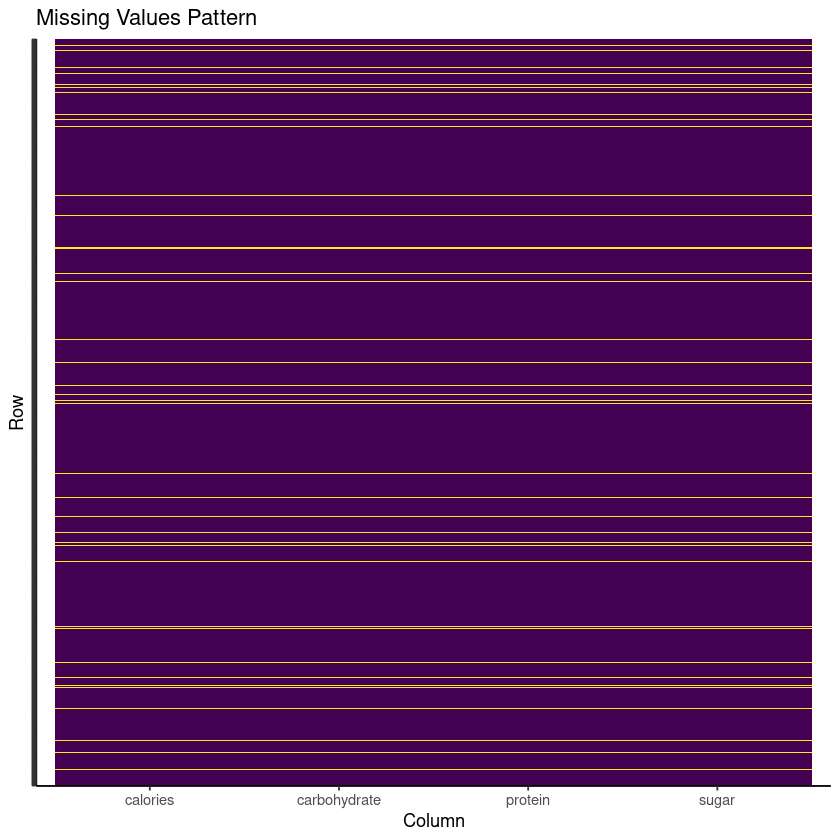

In [4]:
require(tidyverse)
require(viridis)
traffic |> 
	rownames_to_column("row") |>
	select(row, where(is.double)) |>
	pivot_longer(
		-row, 
		names_to = "column", 
		values_to = "value") |>
	mutate(is_na = is.na(value)) |>
	ggplot(aes(x = column, y = row, fill = is_na)) +
	geom_tile() +
	scale_fill_viridis_d(option = "viridis") +
	labs(title = "Missing Values Pattern",
	     x = "Column",
	     y = "Row",
	     fill = "Is NA") +
	theme_classic() +
	theme(
		axis.text.y = element_blank(), 
		legend.position = "none")

It was clear from the chart above that where some missing values existed, they did so for the whole observation (row). There did not appear to be any instances where for an observation some predictors (columns) were present and others missing, they were either all present (95% of observations had all numeric predictors) or all missing (5% of observations had no numerical predictors). 

I considered imputing the missing numerical predictor values, but seeing as I would have to have imputed all numeric predictors for a given observation, I decided that an observation with 4/7 (over half of the) predictors imputed, probably ceased having much utility in the dataset. I opted hence, to drop those rows.

In [5]:
require(tidyverse)
traffic_clean <-
	traffic_clean |>
	drop_na(where(is.double))
traffic_clean |> glimpse()

Rows: 895
Columns: 7
$ calories     <dbl> 35.48, 914.28, 97.03, 27.05, 691.15, 183.94, 299.14, 538.…
$ carbohydrate <dbl> 38.56, 42.68, 30.56, 1.85, 3.46, 47.95, 3.17, 3.78, 48.54…
$ sugar        <dbl> 0.66, 3.09, 38.63, 0.80, 1.65, 9.75, 0.40, 3.37, 3.99, 4.…
$ protein      <dbl> 0.92, 2.88, 0.02, 0.53, 53.93, 46.71, 32.40, 3.79, 113.85…
$ category     <fct> Potato, Breakfast, Beverages, Beverages, One Dish Meal, C…
$ servings     <fct> 4, 1, 4, 4, 2, 4, 4, 6, 2, 1, 6, 4, 4, 4, 6, 2, 1, 6, 2, …
$ high_traffic <fct> High, Low, High, Low, High, Low, Low, High, Low, Low, Low…


In summary, I made the following data validation decisions, resulting in a net loss of only 5% of data.

| Type | Variable | Treatment |
| --- | --- | --- |
| Predictor | `calories` | Dropped missing values (5%). |
| Predictor | `carbohydrates` | Dropped missing values (5%). |
| Predictor | `sugar` | Dropped missing values (5%). |
| Predictor | `protein` | Dropped missing values (5%). |
| Predictor | `category` | Converted to factor. |
| Predictor | `servings` | Removed non-numeric characters, converted to factor. |
| Outcome | `high_traffic` | Inferred missing as low traffic, converted to factor. |

# Exploratory Data Analysis

With data validation complete it was time to explore the variables and understand them more deeply prior to modelling. I began by plotting all the numeric variables and all the categorical variables, to better understand their distribution.

## Factorial Variables

I began by conducting a visual analysis of the factorial variables, to understand distribution and basic skew.

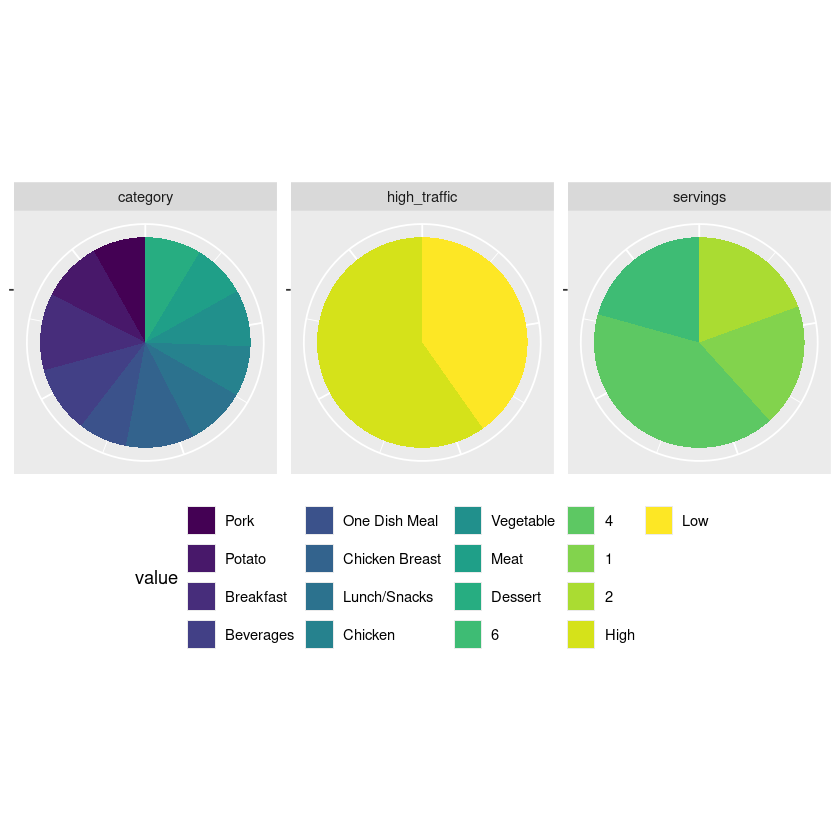

In [6]:
require(tidyverse)
require(viridis)
traffic_clean |>
    select(where(is.factor)) |>
    pivot_longer(
		everything(), 
		names_to = "variable", 
		values_to = "value") |>
    group_by(variable, value) |>
    summarise(n = n(), .groups = "drop") |>
    ggplot(aes(x = "", y = n, fill = value)) +
    geom_col() +
    coord_polar(theta = "y") +
    scale_fill_viridis_d() +
    facet_wrap(~variable, scales = "free") +
    theme(
		axis.title = element_blank(), 
		axis.text = element_blank(), 
		legend.position = "bottom")

For the categorical variables, I used the simple pie charts above to conduct qualitative analyses of each, and made the following findings:

- `category` has all its values evenly distributed, not needing any special consideration.
- `high_traffic`, the outcome variable, was a 60:40 split favouring `High`, to be mindful of in modelling.
- `servings` was skewed towards a value of `4`, which had about twice as many observations as any one other, but still only accounted for less than half the `servings` observations.

I opted to take no particular action to rectify any of these observations, but remain cognisant of them in the modelling phase of the report.

## Numeric Variables

For the numeric variables I began by plotting histograms, for the same purpose as with the factorial variables, to understand distribution and skew. Immediately I noticed a consistent and heavy right skew across all of the numeric variables. I tried transforming them below to see if any blanket transformations to all of them might happen to normalise them.

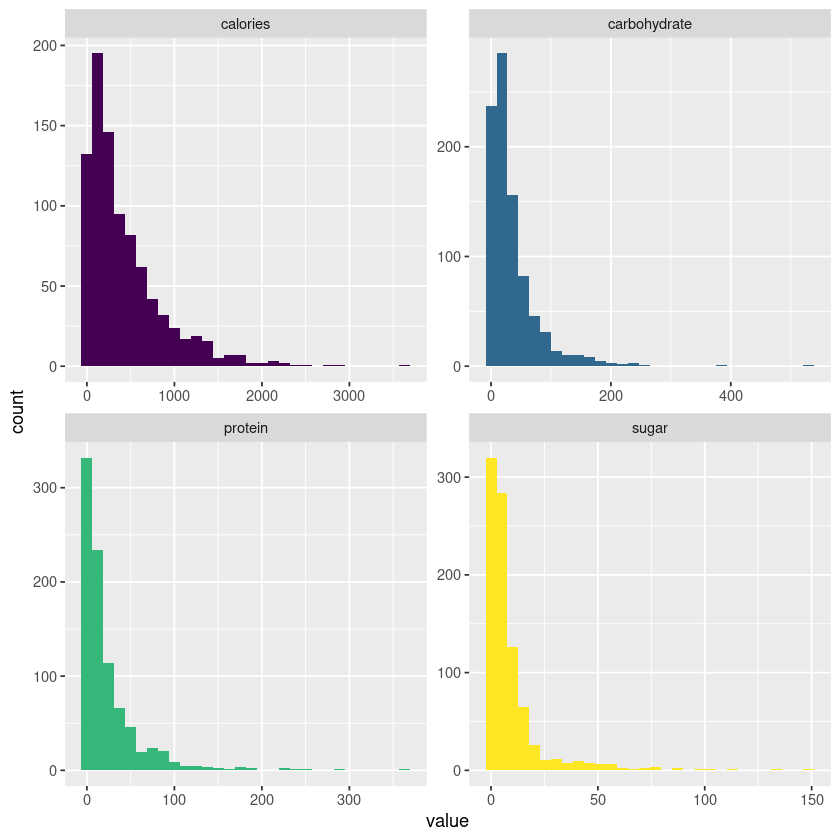

In [7]:
require(tidyverse)
require(viridis)
traffic_clean |>
	select(where(is.double)) |>
	pivot_longer(
		everything(),
		names_to = "variable",
		values_to = "value") |>
	ggplot(aes(x = value, fill = variable)) +
	geom_histogram(bins = 30) +
	scale_fill_viridis_d() +
	facet_wrap(~variable, scales = "free") +
	theme(legend.position = "none")

After initially trying a square root transformation, I settled on the logarithmic transformation above, primarily because it gave the best visual depiction of the different distributions. From the above plots I gathered that although all the numeric predictors were heavily skewed to the right, once I applied a uniform logarithmic transformation, the resultant plots indicated slight differences in the distributions.

After the uniform logarithmic transformation:

- `calories` skewed to the left.
- `carbohydrates` was quite close to a gaussian distribution.
- `protein` and `sugar` remained slightly right skewed.

With this in mind I implemented a Box-Cox transformation with a helper variable so I could re-run and test different λ values. Before I did, I had to check if any of the numeric variables had zero values, which are incompatible with Box-Cox and would necessitate the alternative Yeo-Johnson transformation. I noticed that `protein` had two zero values, so although I could remove two rows without significantly affecting my dataset, I could not be certain if it was an error, and it was just as easy to opt for Yeo-Johnson instead and handle it more gracefully.

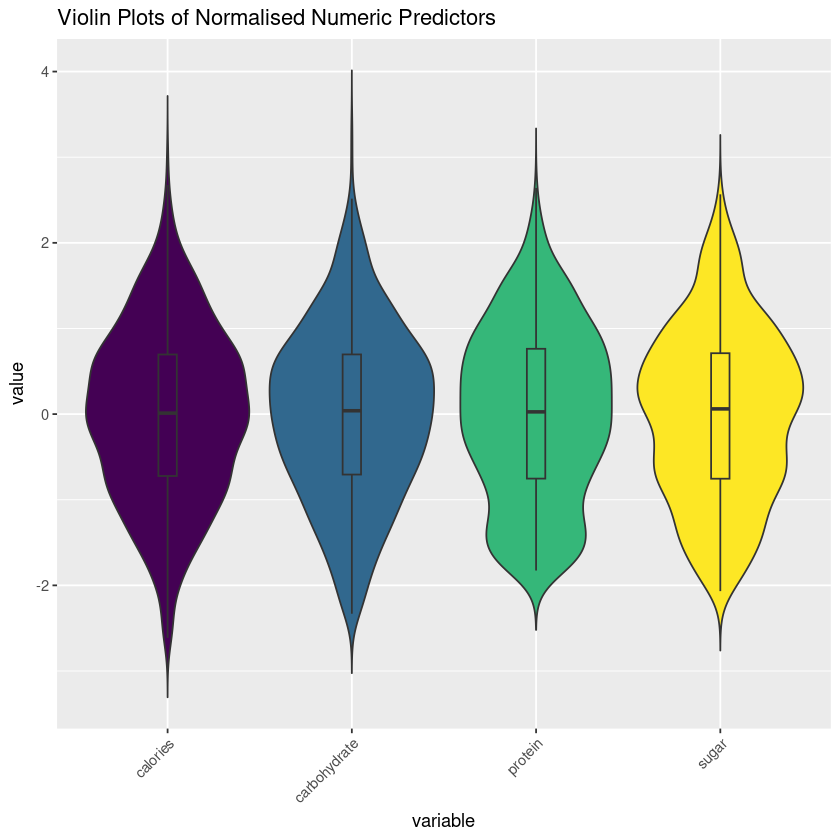

In [8]:

library(tidyverse)
library(tidymodels)
library(viridis)

recipe <- 
  recipe(~ ., data = traffic_clean) |>
  step_YeoJohnson(all_numeric_predictors()) |>
  step_normalize(all_numeric_predictors())

transformed <- prep(recipe) |>
  bake(new_data = NULL)

transformed |>
  select(where(is.numeric)) |>
  pivot_longer(
    everything(), 
    names_to = "variable", 
    values_to = "value"
  ) |>
  filter(is.finite(value)) |>
  ggplot(aes(x = variable, y = value, fill = variable)) +
  geom_violin(trim = FALSE) +
  geom_boxplot(width = 0.1, outlier.shape = NA, alpha = 0.6) +
  scale_fill_viridis_d() +
  labs(title = "Violin Plots of Normalised Numeric Predictors") +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "none"
  )


I did test using the `forecast` package to identify ideal λ values for each predictor rather then my manual uniform transformations, but I found that the results plotted poorly, so chose against implementing it. Another reason for opting against it was the interpretability of my method, whereby feathering λ until plots looked gaussian would be easier to explain than black-box numbers that were difficult to justify upon review of the plots.

I made several summary observations from the EDA process below.

- Factorial Variables:
	- `category` was evenly distributed.
	- `high_traffic` (outcome variable) was 60:40 skewed in favour of `TRUE`.
	- `servings` was skewed to a vlaue of `4`.
- Numeric Variables:
	- `recipe` had two zero values so Box-Cox transformation was not possible without removing them.
	- Yeo-Johnson transformation normalised the variables acceptably.

## Principle Component Analysis

I performed Principal Component Analysis (PCA) as part of the exploratory data analysis to understand the underlying structure of the dataset and reduce its complexity. PCA allowed me to summarise the variation in multiple correlated numeric variables into a smaller set of uncorrelated components. This helped identify which variables contributed most to the overall variance and revealed patterns that were not immediately obvious in the raw data. By visualising the first two principal components, I assessed clustering tendencies, detected potential outliers, and examined relationships between variables, which informed subsequent modelling and feature selection decisions.

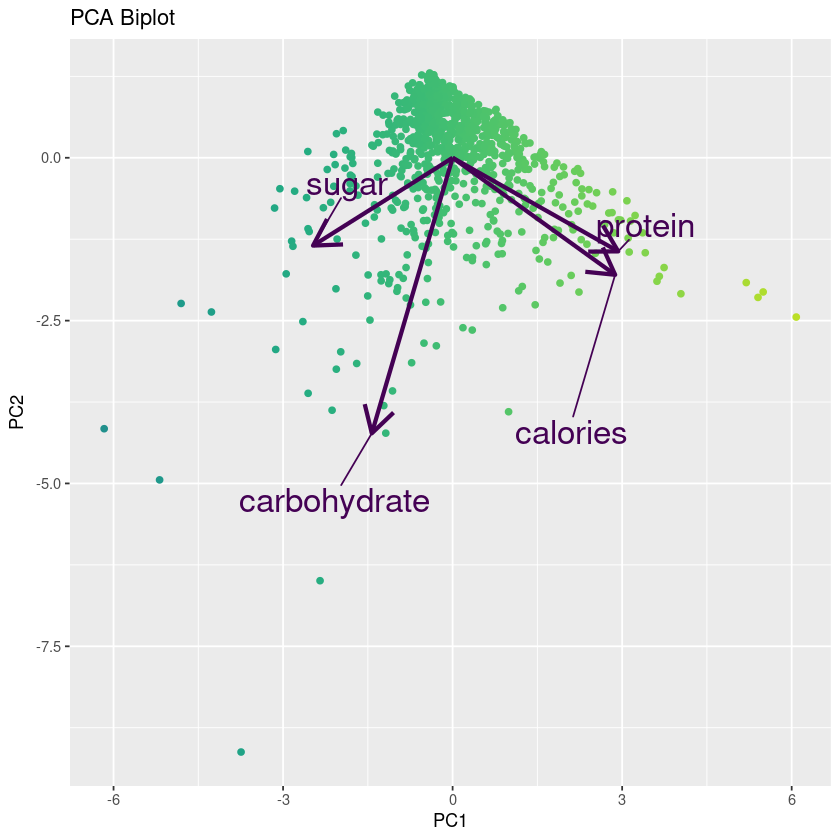

In [30]:
library(tidyverse)
library(tidymodels)
library(ggrepel)
library(viridis)

traffic_pca <- traffic_clean %>%
  select(where(is.numeric)) %>%
  prcomp(scale. = TRUE)

scores <- as_tibble(traffic_pca$x) %>%
  mutate(id = row_number())

loadings <- as_tibble(traffic_pca$rotation, rownames = "variable")

ggplot(scores, aes(x = PC1, y = PC2)) +
    geom_point(aes(color = PC1)) +
    scale_color_viridis(option = "D", begin = 0.5, end = 0.9) +
    geom_segment(data = loadings,
               aes(
				   x = 0, 
				   y = 0, 
				   xend = PC1 * 5, 
				   yend = PC2 * 5),
               arrow = arrow(),
			   linewidth = 1.2,
               color = viridis(1, option = "D")[1]) +
    geom_text_repel(data = loadings,
                    aes(
					  x = PC1 * 5, 
					  y = PC2 * 5, 
					  label = variable),
                    color = viridis(1, option = "D")[1],
					size = 7,
                  	force = 200,
				    ) +
    labs(
	    title = "PCA Biplot", 
	    x = "PC1", 
	    y = "PC2", 
	    color = "PC1") +
	theme(legend.position = "none")

## Multicollinearity

With an understanding of each variable distribution and skew, I assessed the multicollinearity of variables, particularly since the numeric variables fell into line so easily with the same λ from the Box-Cox transformation.

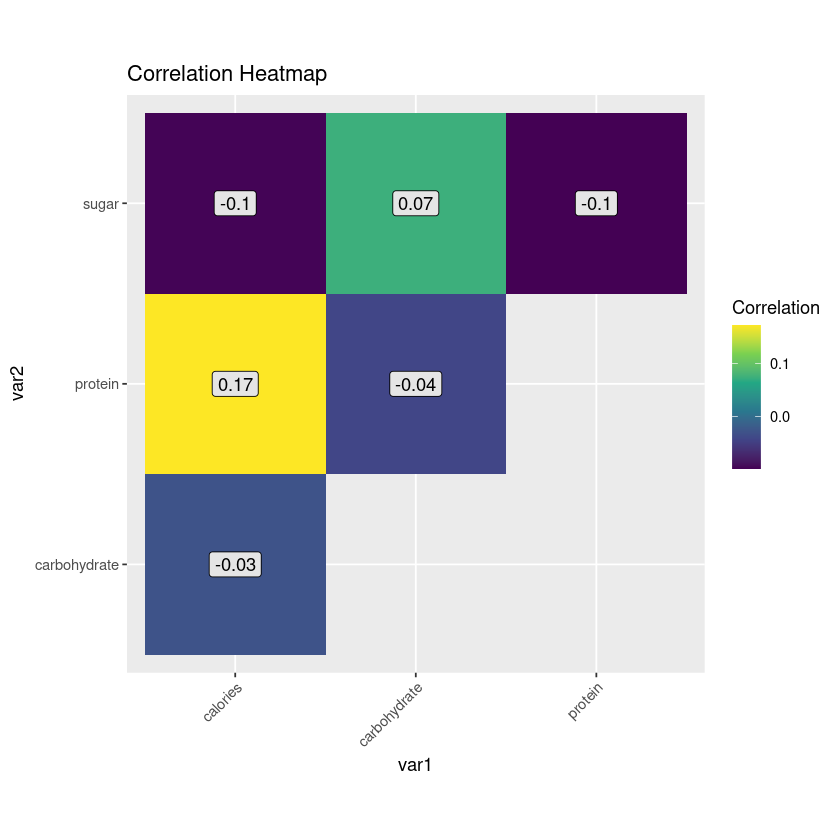

In [10]:
require(tidyverse)
require(viridis)
traffic_clean |>
    select(where(is.double)) |>
    cor(use = "pairwise.complete.obs") |>
    as.data.frame() |>
    rownames_to_column("var1") |>
    pivot_longer(-var1, names_to = "var2", values_to = "correlation") |>
    filter(var1 < var2) |>
    ggplot(aes(x = var1, y = var2, fill = correlation)) +
    geom_tile() +
    geom_label(aes(label = round(correlation, 2)), fill = "grey90", color = "black") +
    scale_fill_viridis_c() +
    labs(title = "Correlation Heatmap", fill = "Correlation") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    coord_fixed()

My plot of the correlation between numeric variables clearly indicated no significant multicollinearity in my numeric predictors. Specifically, although `protein` and `calories` had the highest correlation of `0.17` but that was still very low. I interpreted that there was very little correlation between any numeric predictors, and concluded that multicollinearity was not a major issue in this dataset prior to modelling.

# Data Engineering

Prior to model development, I undertook several steps to prepare my data and analysis space for ease of subsequent modelling.

## Data Splitting

After EDA and before I could begin with the modelling itself, I first had to split the data for the primary goal of avoiding data leakage, and to ensure fair and consistent model metrics. With 895 observations, I opted for a 80:20 training-validation split, with a further 10-fold Cross Validation (CV) split of the training set with resampling. This was to have test data available for model tuning and iteration, while also holding out a validation set for final evaluation.

| Split | % | Purpose |
| --- | --- | --- |
| Training | 60% CV Folds | Model training. |
| Testing | 20% CV Folds | Model testing and interation. |
| Validation | 20% | Final evaluation. |

In [11]:
require(tidymodels)

for (var in c("splits", "training", "validation", "folds")) {
  if (exists(var)) {
    rm(list = var)
  }
}

splits <- 
	initial_split(
		traffic_clean, 
		prop = 0.8, 
		strata = high_traffic)
training <- 
	training(splits)
validation <- 
	testing(splits)
folds <- 
	vfold_cv(
		training, 
		v = 10, 
		strata = high_traffic)

Warning message in rm(list = var):
“object 'training' not found”
Warning message in rm(list = var):
“object 'validation' not found”


## Evaluation Storage

To compare and evaluate models, I create a table to store key metrics:
- **Accuracy** was the mean number of correct predictions in the test set across the cross validation folds.
- **ROC AUC** was the Receiver Operating Characteristic (ROC) Area Under Curve (AUC) summary statistic describing efficacy of the model across different classification thresholds.

In [12]:
require(tidyverse)
if (exists("metrics_table")) {
	rm(metrics_table)
}
metrics_table <- 
	tibble(
  		"Model Name" = character(),
		"Accuracy" = numeric(),
		"ROC AUC" = numeric()
)

add_metrics <- function(result, model_name) {
    require(tidyverse)
    require(tidymodels)

    metrics_table <<- metrics_table |>
        filter(`Model Name` != model_name) |>
        bind_rows(
            collect_metrics(result) |>
                filter(.metric %in% c("accuracy", "roc_auc")) |>
                select(.metric, mean) |>
                pivot_wider(names_from = .metric, values_from = mean) |>
                mutate(
                    `Model Name` = model_name,
                    accuracy = round(accuracy, 2),
                    roc_auc = round(roc_auc, 2)
                ) |>
                select(`Model Name`, Accuracy = accuracy, `ROC AUC` = roc_auc)
        ) |>
        arrange(desc(`ROC AUC`))
}

plot_roc_curves <- function(results_list, model_names) {
    require(tidyverse)
    require(tidymodels)
    require(viridis)
    roc_data <- map2_dfr(results_list, model_names, ~ {
        collect_predictions(.x) |>
            roc_curve(truth = high_traffic, .pred_High) |>
            mutate(Model = .y)
    })
    ggplot(roc_data, aes(x = 1 - specificity, y = sensitivity, color = Model)) +
        geom_path(linewidth = 1) +
        geom_abline(lty = 2, color = "gray") +
		scale_color_viridis_d(option = "D") +
        labs(
            title = "ROC Curves",
            x = "False Positive Rate (1 - Specificity)",
            y = "True Positive Rate (Sensitivity)",
            color = "Model"
        )
}

## Recipe

I created a recipe to transform the data for modelling. I applied one-hot encoding to all categorical predictors so algorithms could interpret them as numeric features. I used the Yeo-Johnson transformation on numeric predictors to reduce skewness and stabilise variance. I normalised all numeric predictors because models such as k-nearest neighbours rely on distance calculations and require predictors on a similar scale. I removed zero-variance predictors because they added no useful information and could cause computational issues. This approach produced a consistent and robust preprocessing pipeline suitable for all models in the workflow.

In [13]:
require(tidyverse)
require(tidymodels)

recipe <-
	recipe(
		high_traffic ~ .,
		data=traffic_clean) |>
	step_dummy(
		all_nominal_predictors(), 
		one_hot = TRUE) |>
	step_YeoJohnson(all_numeric_predictors()) |>
	step_normalize(all_numeric_predictors()) |>
	step_zv(all_predictors()) |>
	step_nzv(all_predictors())

# Model Development

As foreshadowed, I followed the modelling process from [Tidy Modeling with R](https://www.tmwr.org/). This involved a structured process that splits data, preprocesses it with recipes, specifies and tunes models using resampling, and evaluates performance with consistent, reproducible steps.

## Null Model

Prior to beginning real model fitting, I chose to create a null model. In this case, the binary categorical outcome variable was skewed 60:40 toward `high_traffic` being `TRUE`, so the data alone could predict correct class 60% of the time. It was important to capture this in a baseline null model, so that I could measure my improvements based on the data. I create a null model based solely on the marginal distribution of the outcome variable, ignoring all predictors. It was at this point that I also created a recipe, encoding the formula and importantly, creating dummy variables from the categorical variables to maximise model intercompatibility.

Model Name,Accuracy,ROC AUC
<chr>,<dbl>,<dbl>
Null Model,0.6,0.5


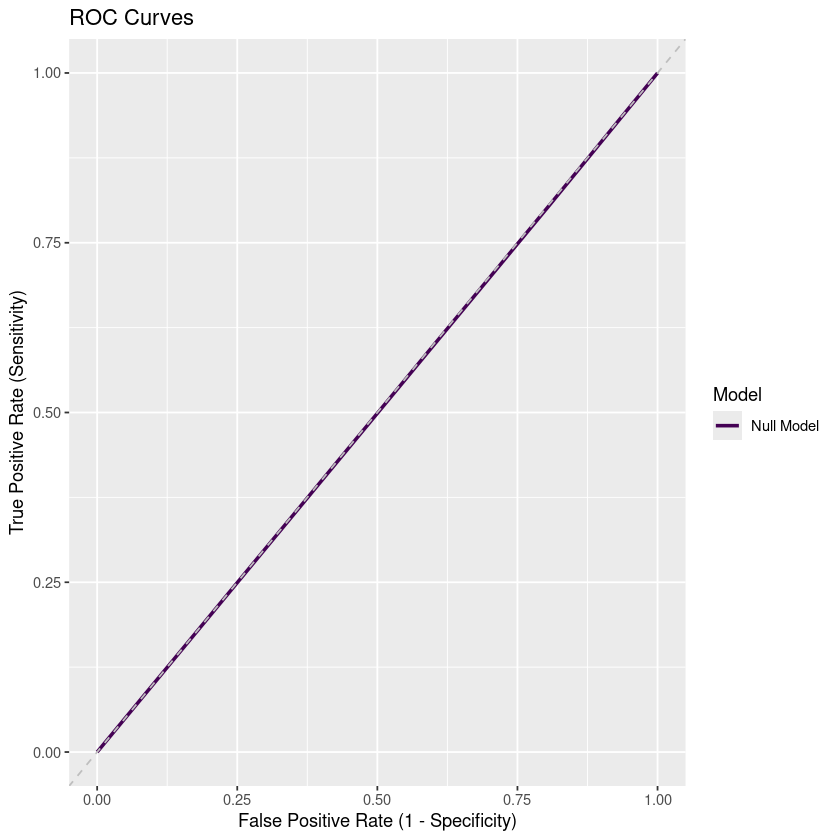

In [14]:
require(tidyverse)
require(tidymodels)

spec_1_null <-
	null_model() |>
	set_mode("classification") |>
	set_engine("parsnip")
workflow_1_null <-
	workflow() |>
	add_model(spec_1_null) |>
	add_recipe(recipe)
result_1_null <-
	fit_resamples(
		workflow_1_null,
		resamples = folds,
		control = control_resamples(save_pred = TRUE)
	)

add_metrics(result_1_null, "Null Model")
metrics_table

plot_roc_curves(
    results_list = list(result_1_null),
    model_names = c("Null Model")
)

The Null Model, forming baseline for further model development, had ROC AUC of 0.5, and an accuracy of 0.6. For the sake of consitency I used the same method of iterating over the cross validation folds, and the result of `0.6` accuracy showed that the method was appropriate.

## Logistic Regression

For the purpose of explainable iterations, I began with the simplest possible predictive model, a logistic regression model. This model type is the classification equivalent of a multiple linear regression (or in the case of a single variable, a simple linear regression).

Model Name,Accuracy,ROC AUC
<chr>,<dbl>,<dbl>
Logistic Regression,0.76,0.84
Null Model,0.60,0.50


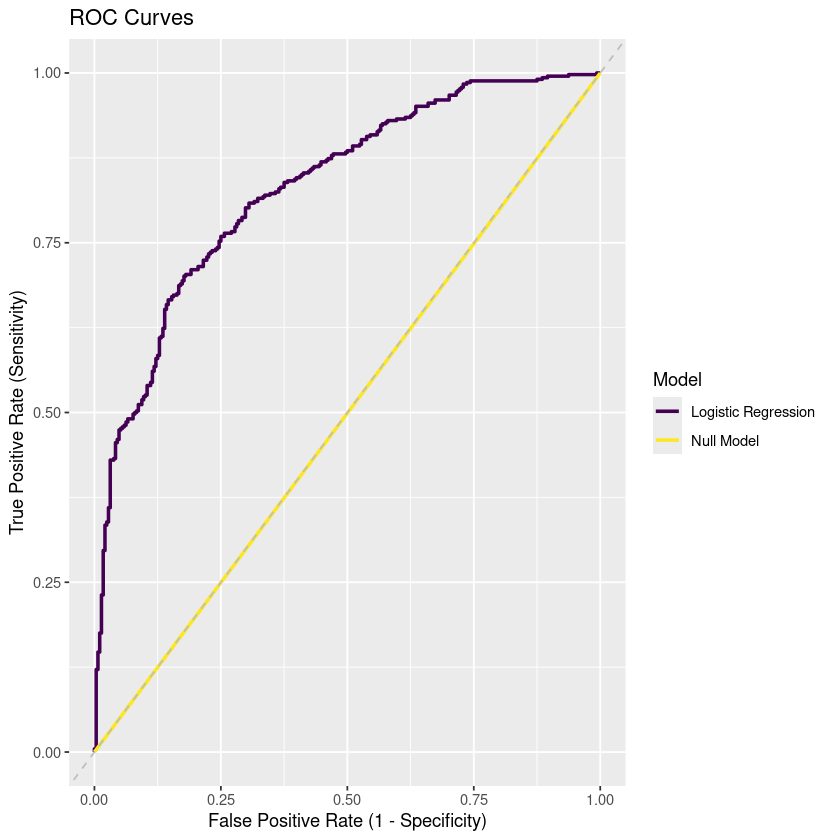

In [15]:
require(tidyverse)
require(tidymodels)

spec_2_logistic <-
	logistic_reg() |>
	set_mode("classification") |>
	set_engine("glm")
workflow_2_logistic <-
	workflow() |>
	add_model(spec_2_logistic) |>
	add_recipe(recipe)
result_2_logistic <-
	fit_resamples(
		workflow_2_logistic,
		resamples = folds,
		control = control_resamples(save_pred = TRUE)
	)

add_metrics(result_2_logistic, "Logistic Regression")
metrics_table

plot_roc_curves(
    results_list = list(
		result_1_null, 
		result_2_logistic),
    model_names = c(
		"Null Model", 
		"Logistic Regression")
)

The ROC curve shows that the logistic regression model performed substantially better than the null model, which followed the diagonal line representing random classification. The curve for logistic regression rises quickly toward the top-left corner, indicating strong sensitivity at low false positive rates. While this is an encouraging start, it reflects only the initial modelling effort and leaves room for improvement through further tuning and exploration of alternative algorithms.

## Regularised Logistic Regression

A regularised logistic regression introduces a penalty term (LASSO or Ridge) that shrinks the coefficients, reducing overfitting and improving predictive perforamnce. Although there was no immediate indicators of multicollinearity in the EDA, I thought it would still be worthwhile to extend the logistic regression with a regularised version. I created a grid of twenty possible penalty values on a logarithmic scale, then ran cross validation for every possible penalty value to determine which penalty value yielded the best ROC AUC. I picked the best penalty value as a final result for comparison to previous models.

Model Name,Accuracy,ROC AUC
<chr>,<dbl>,<dbl>
Logistic Regression,0.76,0.84
Regularised Logistic Regression,0.76,0.84
Null Model,0.60,0.50


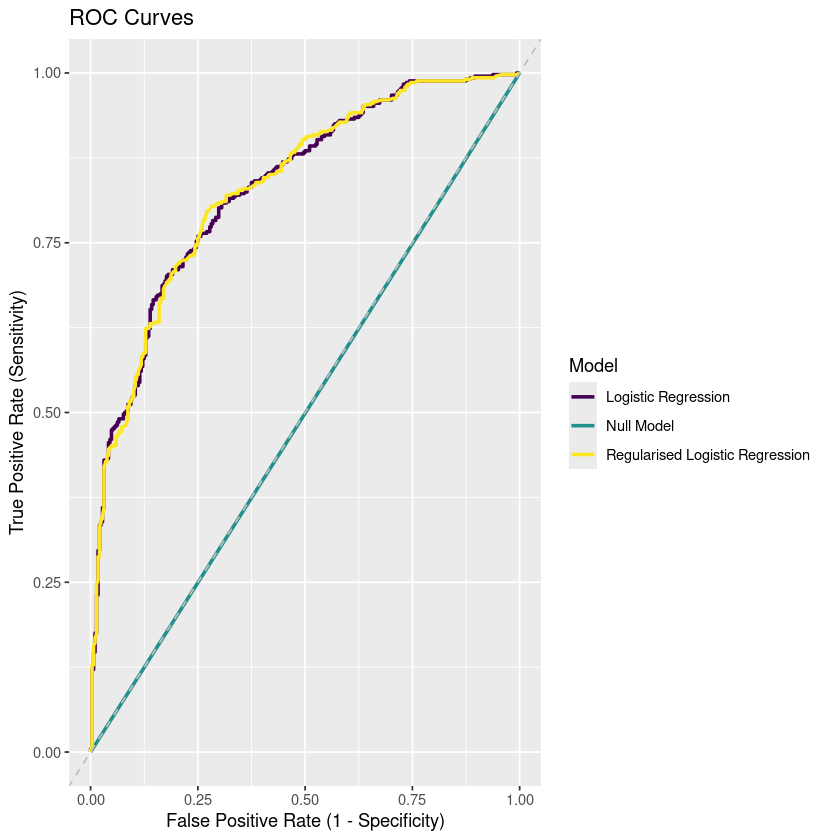

In [16]:
require(tidyverse)
require(tidymodels)
spec_3_regularised_logistic <-
    logistic_reg(
        penalty = tune(),
        mixture = 1
    ) |>
    set_mode("classification") |>
    set_engine("glmnet")
workflow_3_regularised_logistic <-
    workflow() |>
    add_model(spec_3_regularised_logistic) |>
    add_recipe(recipe)
grid <-
    grid_regular(penalty(), levels = 20)
tune_grid <-
    tune_grid(
        workflow_3_regularised_logistic,
        resamples = folds,
        grid = grid,
        control = control_grid(save_pred = TRUE)
    )
best_params <- select_best(tune_grid, metric = "roc_auc")
final_workflow <- finalize_workflow(workflow_3_regularised_logistic, best_params)
#best_params |> select(-.config)

result_3_regularised_logistic <- fit_resamples(
    final_workflow,
    resamples = folds,
    control = control_resamples(save_pred = TRUE)
)

add_metrics(result_3_regularised_logistic, "Regularised Logistic Regression")
metrics_table

plot_roc_curves(
    results_list = list(
		result_1_null, 
		result_2_logistic, 
		result_3_regularised_logistic),
    model_names = c(
		"Null Model", 
		"Logistic Regression", 
		"Regularised Logistic Regression")
)

rm(grid, tune_grid, best_params, final_workflow)

The ROC curves for logistic regression and its regularised variant were almost indistinguishable, showing that tuning did not deliver a visible improvement in classification performance. However, the evaluation table indicated a modest gain of a few percentage points in accuracy and ROC AUC after applying regularisation. This suggests that while the visual profile remained largely unchanged, tuning added incremental value that could matter in more demanding scenarios.

## Decision Tree

Taking a different approach, I implementd a decision tree model, which applies a different approach to logistic regressions and attempts to subdivided the feature space by the outcome variable. I had no particular expectations about how this might perform, except with the prior knowledge that tree-based models are generally quite versatile.

Model Name,Accuracy,ROC AUC
<chr>,<dbl>,<dbl>
Logistic Regression,0.76,0.84
Regularised Logistic Regression,0.76,0.84
Decision Tree,0.76,0.77
Null Model,0.60,0.50


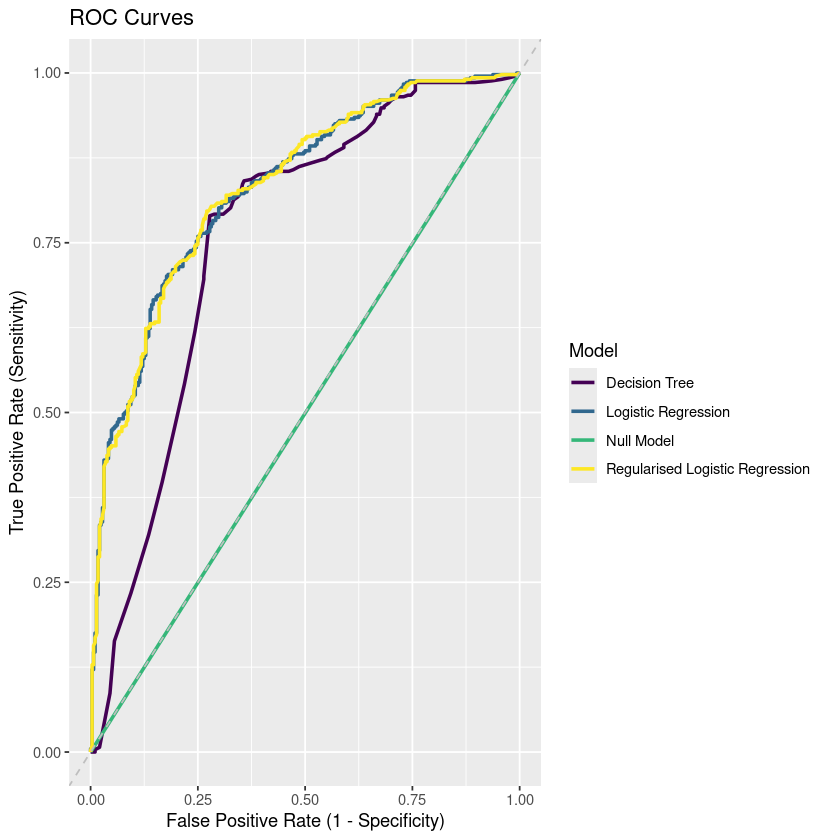

In [17]:
require(tidyverse)
require(tidymodels)

spec_4_decision_tree <-
    decision_tree() |>
    set_mode("classification") |>
    set_engine("rpart")
workflow_4_decision_tree <-
    workflow() |>
    add_model(spec_4_decision_tree) |>
    add_recipe(recipe)
result_4_decision_tree <-
	fit_resamples(
		workflow_4_decision_tree,
		resamples = folds,
		control = control_resamples(save_pred = TRUE)
	)

add_metrics(result_4_decision_tree, "Decision Tree")
metrics_table

plot_roc_curves(
    results_list = list(
		result_1_null, 
		result_2_logistic,
		result_3_regularised_logistic, 
		result_4_decision_tree),
    model_names = c(
		"Null Model", 
		"Logistic Regression",
		"Regularised Logistic Regression", 
		"Decision Tree")
)

The decision tree showed a noticeably different ROC curve profile compared to the logistic regression models, reflecting its non-linear approach to classification. While it did not match the overall performance of logistic regression, the curve demonstrated that the model captured some structure in the data, particularly at lower false positive rates. This variation indicated that tree-based methods offered an alternative perspective on the problem, even if the initial implementation was less effective. It provided a useful baseline for exploring whether tuning could enhance its predictive capability.

## Tuned Decision Tree

For the sake of completeness, I opted to tune my decision tree as I had the logistic regress. I expected little improvement, since the regularised (tuned) logistic regression had not yielded much improvement. This time I combined the tuning code into a single step, adding the best results to the table and plotting the best against all prior ROC curves.

Model Name,Accuracy,ROC AUC
<chr>,<dbl>,<dbl>
Logistic Regression,0.76,0.84
Regularised Logistic Regression,0.76,0.84
Tuned Tree,0.70,0.79
Decision Tree,0.76,0.77
Null Model,0.60,0.50


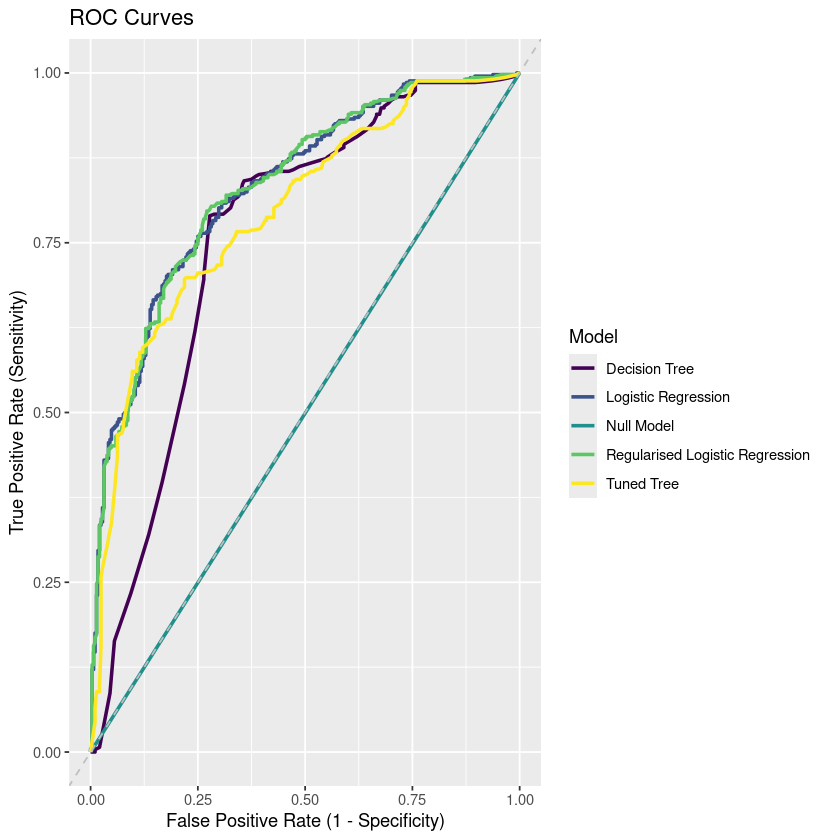

In [18]:
require(tidyverse)
require(tidymodels)

spec_5_tuned_tree <-
	decision_tree(
		cost_complexity = tune(),
		tree_depth = tune(),
		min_n = tune()
	) |>
	set_mode("classification") |>
	set_engine("rpart")
workflow_5_tuned_tree <-
	workflow() |>
	add_model(spec_5_tuned_tree) |>
	add_recipe(recipe)

tune_grid <-
	tune_grid(
		workflow_5_tuned_tree,
		resamples = folds,
		grid = 10,
		control = control_grid(save_pred = TRUE)
	)
best_params <- select_best(tune_grid, metric = "roc_auc")
final_workflow <- finalize_workflow(workflow_5_tuned_tree, best_params)
#best_params |> select(-.config)

result_5_tuned_tree <-
	fit_resamples(
		final_workflow,
		resamples = folds,
		control = control_resamples(save_pred = TRUE)
	)
add_metrics(result_5_tuned_tree, "Tuned Tree")
metrics_table

plot_roc_curves(
	results_list = list(
		result_1_null, 
		result_2_logistic, 
		result_3_regularised_logistic,
		result_4_decision_tree,
		result_5_tuned_tree),
	model_names = c(
		"Null Model", 
		"Logistic Regression",
		"Regularised Logistic Regression", 
		"Decision Tree",
		"Tuned Tree")
)

rm(tune_grid, best_params, final_workflow)

The tuned decision tree delivered only a modest improvement in accuracy and ROC AUC compared to the simple tree, yet its ROC curve showed a noticeably different profile. Unlike the regularised logistic regression, which appeared almost identical to its base model, tuning the tree produced a curve that tracked much closer to the top-left corner, indicating better discrimination across thresholds. This visual improvement aligned with the incremental gains reported in the evaluation table. The contrast between the quantitative and qualitative perspectives highlighted the value of examining both metrics and curve shapes when assessing model performance.

## Random Forest

I selected a random forest model because it combines multiple decision trees into an ensemble, reducing variance and improving generalisation compared to a single tree. This approach is well suited for classification tasks with mixed predictor types and potential non-linear relationships. I chose it to explore whether an ensemble method could capture complex interactions in the data more effectively than simpler models.

Model Name,Accuracy,ROC AUC
<chr>,<dbl>,<dbl>
Logistic Regression,0.76,0.84
Regularised Logistic Regression,0.76,0.84
Random Forest,0.76,0.83
Tuned Tree,0.70,0.79
Decision Tree,0.76,0.77
Null Model,0.60,0.50


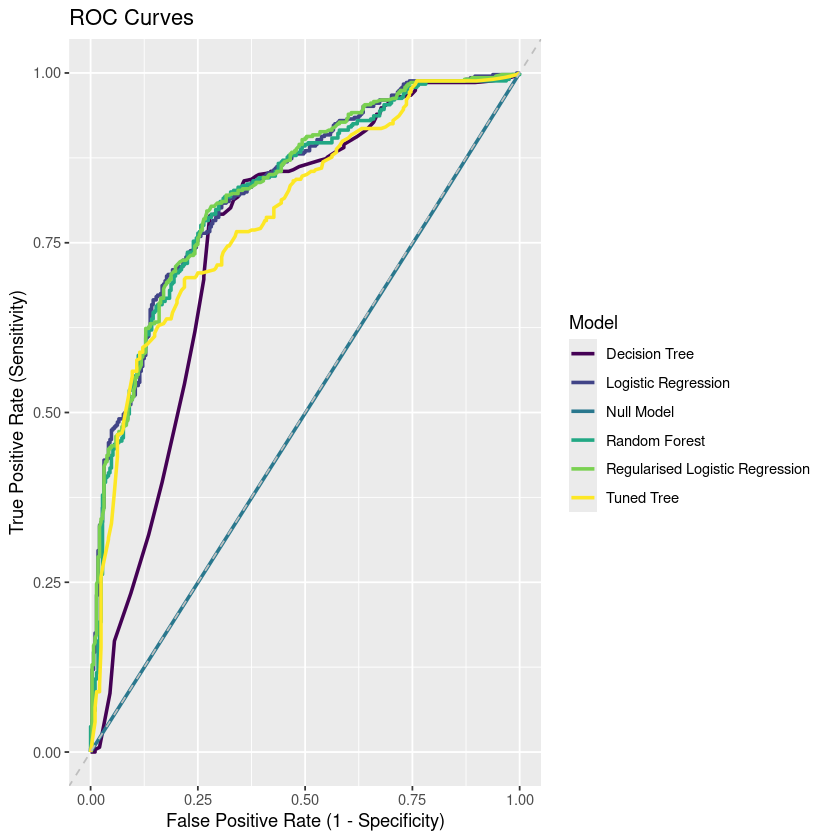

In [19]:
require(tidyverse)
require(tidymodels)

spec_6_random_forest <-
	rand_forest() |>
	set_mode("classification") |>
	set_engine("ranger")

workflow_6_random_forest <-
	workflow() |>
	add_model(spec_6_random_forest) |>
	add_recipe(recipe)

result_6_random_forest <-
	fit_resamples(
		workflow_6_random_forest,
		resamples = folds,
		control = control_resamples(save_pred = TRUE)
	)

add_metrics(result_6_random_forest, "Random Forest")
metrics_table

plot_roc_curves(
	results_list = list(
		result_1_null, 
		result_2_logistic, 
		result_3_regularised_logistic,
		result_4_decision_tree,
		result_5_tuned_tree,
		result_6_random_forest),
	model_names = c(
		"Null Model", 
		"Logistic Regression",
		"Regularised Logistic Regression", 
		"Decision Tree",
		"Tuned Tree",
		"Random Forest")
)

Applying the principle of parsimony, or Occam’s Razor, favours the simplest model that explains the data while delivering strong predictive performance. In this case, the ROC curves show that regularised logistic regression performed almost as well as more complex models such as random forest and tuned decision trees. Given its interpretability, computational efficiency, and lower risk of overfitting, logistic regression would have been a practical choice at this stage. I proceeded with additional modelling strategies to demonstrate a range of approaches, acknowledging that in a real-world setting, regularised logistic regression could have been considered sufficiently effective.

## k-Nearest Neighbours (KNN)

I included a k-nearest neighbours model because it is a simple, instance-based learning algorithm that classifies observations based on the majority class among their closest neighbours. This method does not assume a specific functional form, making it useful for capturing local patterns in the data. I chose KNN to evaluate whether proximity-based classification could provide insights beyond the parametric and tree-based approaches.

In [20]:
require(tidyverse)
require(tidymodels)

spec_7_knn <-
  nearest_neighbor(
    neighbors = tune()
  ) |>
  set_mode("classification") |>
  set_engine("kknn")

workflow_7_knn <-
  workflow() |>
  add_model(spec_7_knn) |>
  add_recipe(recipe)

tune_grid <- tune_grid(
  workflow_7_knn,
  resamples = folds,
  grid = 10,
  control = control_grid(save_pred = TRUE)
)


best_params <- select_best(tune_grid, metric = "roc_auc")
final_workflow <- finalize_workflow(workflow_7_knn, best_params)
#best_params

result_7_knn <-
  fit_resamples(
    final_workflow,
    resamples = folds,
    control = control_resamples(save_pred = TRUE)
  )

add_metrics(result_7_knn, "k-Nearest Neighbours")

rm(tune_grid, best_params, final_workflow)

→ A | warning: variable '..y' is absent, its contrast will be ignored

There were issues with some computations   A: x1

There were issues with some computations   A: x4

There were issues with some computations   A: x10

There were issues with some computations   A: x10



→ A | warning: variable '..y' is absent, its contrast will be ignored



Model Name,Accuracy,ROC AUC
<chr>,<dbl>,<dbl>
Logistic Regression,0.76,0.84
Regularised Logistic Regression,0.76,0.84
Random Forest,0.76,0.83
k-Nearest Neighbours,0.73,0.82
Tuned Tree,0.70,0.79
Decision Tree,0.76,0.77
Null Model,0.60,0.50


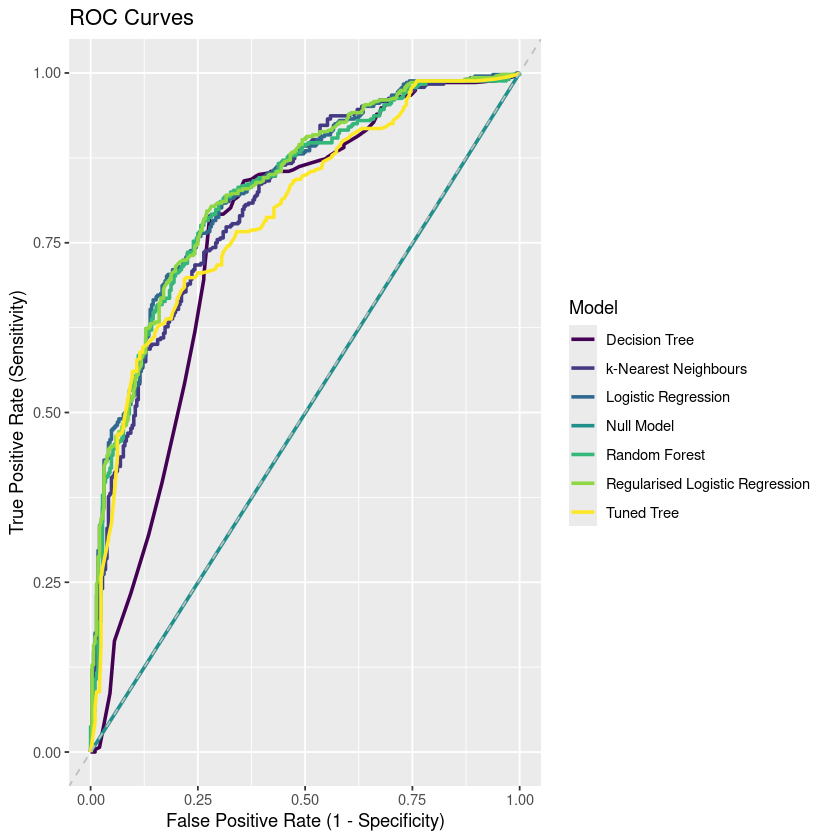

In [21]:
metrics_table

plot_roc_curves(
  results_list = list(
    result_1_null, 
    result_2_logistic, 
    result_3_regularised_logistic,
    result_4_decision_tree,
    result_5_tuned_tree,
    result_6_random_forest,
    result_7_knn),
  model_names = c(
    "Null Model", 
    "Logistic Regression",
    "Regularised Logistic Regression", 
    "Decision Tree",
    "Tuned Tree",
    "Random Forest",
    "k-Nearest Neighbours")
)

The ROC curve for k-nearest neighbours showed a profile broadly similar to the other models, though it did not outperform the simpler approaches. Its curve tracked close to the logistic regression and random forest lines, indicating reasonable discrimination but no clear advantage. This outcome highlighted the limitations of instance-based methods in this context, where the data may not exhibit strong local clustering. Including KNN was still valuable as it demonstrated how a non-parametric, distance-based algorithm compares to parametric and ensemble approaches within the same modelling framework.

## Neural Network

I implemented a neural network as part of the modelling process to explore a broader range of techniques. The decision was not driven by the complexity of the problem but by the opportunity to test different approaches and compare their performance. I configured the model using a multilayer perceptron specification, tuning parameters such as hidden units, penalty, and epochs. This allowed me to evaluate how a neural network performed relative to other models in terms of classification accuracy and ROC curves.

Model Name,Accuracy,ROC AUC
<chr>,<dbl>,<dbl>
Logistic Regression,0.76,0.84
Regularised Logistic Regression,0.76,0.84
Random Forest,0.76,0.83
k-Nearest Neighbours,0.73,0.82
MLP,0.75,0.81
Tuned Tree,0.70,0.79
Decision Tree,0.76,0.77
Null Model,0.60,0.50


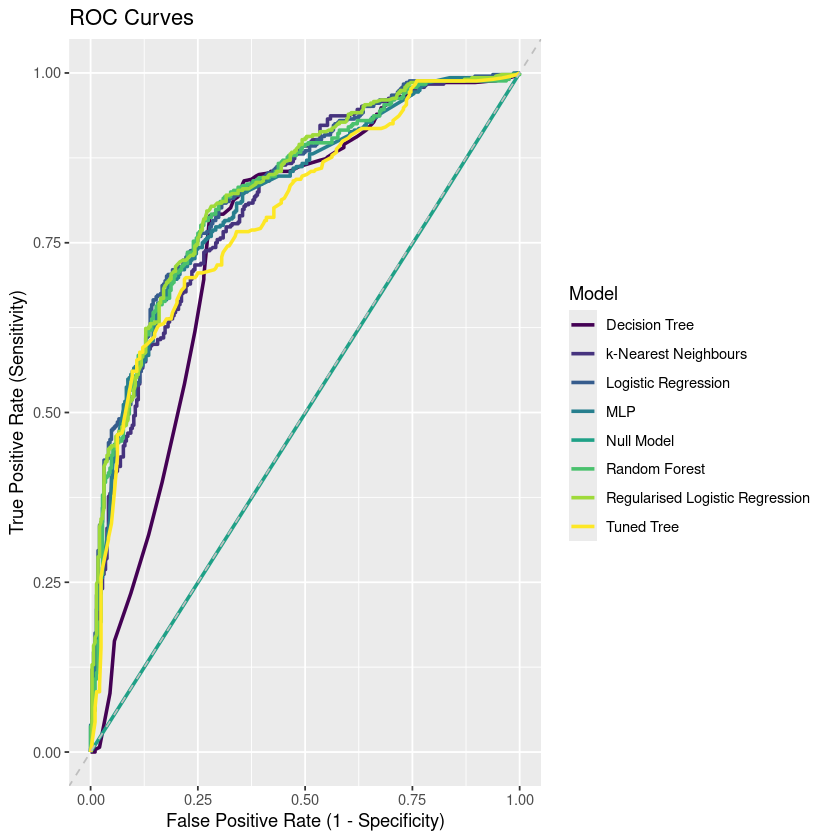

In [22]:

require(tidyverse)
require(tidymodels)

spec_8_mlp <-
  mlp(
    hidden_units = tune(),
    penalty = tune(),
    epochs = tune()
  ) |>
  set_mode("classification") |>
  set_engine("nnet")
workflow_8_mlp <-
  workflow() |>
  add_model(spec_8_mlp) |>
  add_recipe(recipe)

tune_grid <-
  tune_grid(
    workflow_8_mlp,
    resamples = folds,
    grid = 10, 
    control = control_grid(save_pred = TRUE)
  )
best_params <- select_best(tune_grid, metric = "roc_auc")
final_workflow <- finalize_workflow(workflow_8_mlp, best_params)
#best_params

result_8_mlp <-
  fit_resamples(
    final_workflow,
    resamples = folds,
    control = control_resamples(save_pred = TRUE)
  )

add_metrics(result_8_mlp, "MLP")
metrics_table

plot_roc_curves(
  results_list = list(
    result_1_null, 
    result_2_logistic, 
    result_3_regularised_logistic,
    result_4_decision_tree,
    result_5_tuned_tree,
    result_6_random_forest,
    result_7_knn,
    result_8_mlp),
  model_names = c(
    "Null Model", 
    "Logistic Regression",
    "Regularised Logistic Regression", 
    "Decision Tree",
    "Tuned Tree",
    "Random Forest",
    "k-Nearest Neighbours",
    "MLP")
)

rm(tune_grid, best_params, final_workflow)

The ROC curve for the multilayer perceptron (MLP) model was broadly comparable to the other strong performers, indicating that it captured some non-linear relationships. However, the tuned configuration revealed only one hidden unit, which suggests that the optimisation process found little benefit in adding complexity. This outcome implies that the dataset did not present substantial non-linear patterns requiring deeper architectures, reinforcing that simpler models such as regularised logistic regression were sufficient. Including the MLP was still valuable as it demonstrated how tuning can reveal when additional complexity is unwarranted.

# Model Evaluation

I evaluated each model to understand its predictive performance and ensure it generalised beyond the training data. I began by splitting the dataset into training, testing, and validation sets to avoid data leakage and maintain fairness in the evaluation process. I applied 10-fold cross-validation on the training set to obtain robust estimates of model performance across different subsets of data.

For classification models, I focused on accuracy and ROC AUC as my primary metrics. Accuracy gave me a clear measure of correct predictions, while ROC AUC provided insight into how well the model distinguished between classes across varying thresholds. I complemented these numeric metrics with visual tools such as ROC curves and confusion matrices, which helped me interpret threshold sensitivity and error patterns. These plots allowed me to see where models performed well and where misclassifications occurred.

I also considered interpretability and complexity when comparing models. While more complex models like random forests offered strong predictive power, simpler models such as logistic regression were easier to explain and less prone to overfitting. This reinforced the principle of parsimony: favouring the simplest model that achieved acceptable performance. By combining quantitative metrics with qualitative visualisations, I ensured that my evaluation process was both rigorous and transparent.

## Qualitiative

Equally important, I also conducted a visual analysis of the ROC curves as part of the model evaluation process.

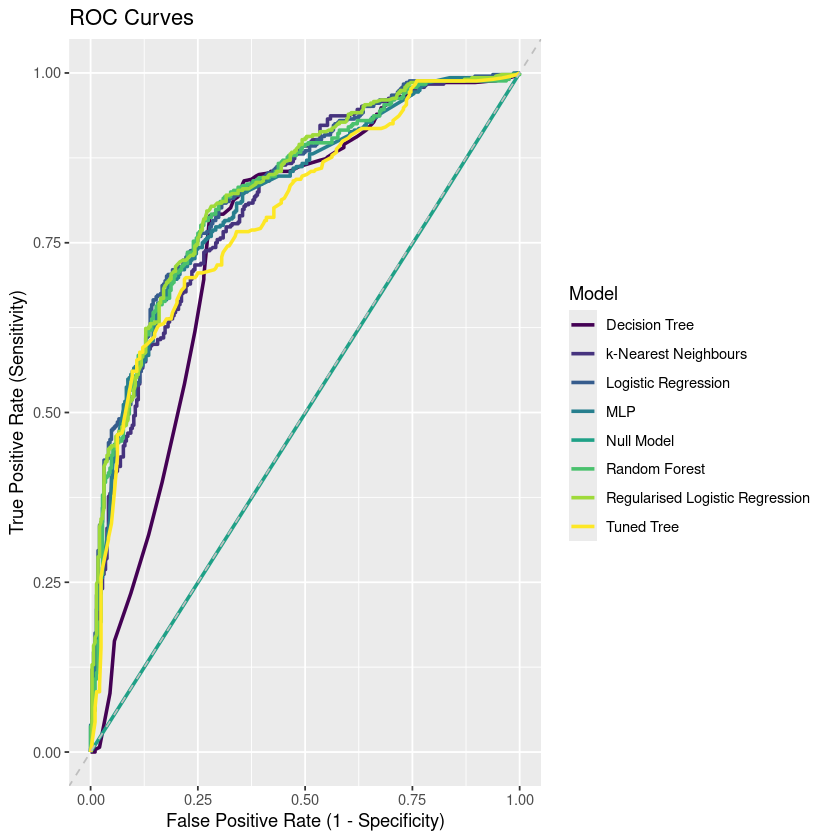

In [23]:
plot_roc_curves(
  results_list = list(
    result_1_null, 
    result_2_logistic, 
    result_3_regularised_logistic,
    result_4_decision_tree,
    result_5_tuned_tree,
    result_6_random_forest,
    result_7_knn,
    result_8_mlp),
  model_names = c(
    "Null Model", 
    "Logistic Regression",
    "Regularised Logistic Regression", 
    "Decision Tree",
    "Tuned Tree",
    "Random Forest",
    "k-Nearest Neighbours",
    "MLP")
)

The ROC curves show that logistic regression, regularised logistic regression, and random forest maintained strong performance, with curves rising steeply toward the top-left corner and remaining close to each other across thresholds. The multilayer perceptron and k-nearest neighbours also tracked closely behind, indicating comparable discrimination ability despite their differing modelling approaches. The tuned decision tree improved noticeably over the simple tree, with a curve that shifted upward, though both remained below the leading models. The null model followed the diagonal line, confirming its baseline status. Overall, the chart reinforces that simpler models performed as well as or better than more complex alternatives, and tuning provided only incremental gains in this context.

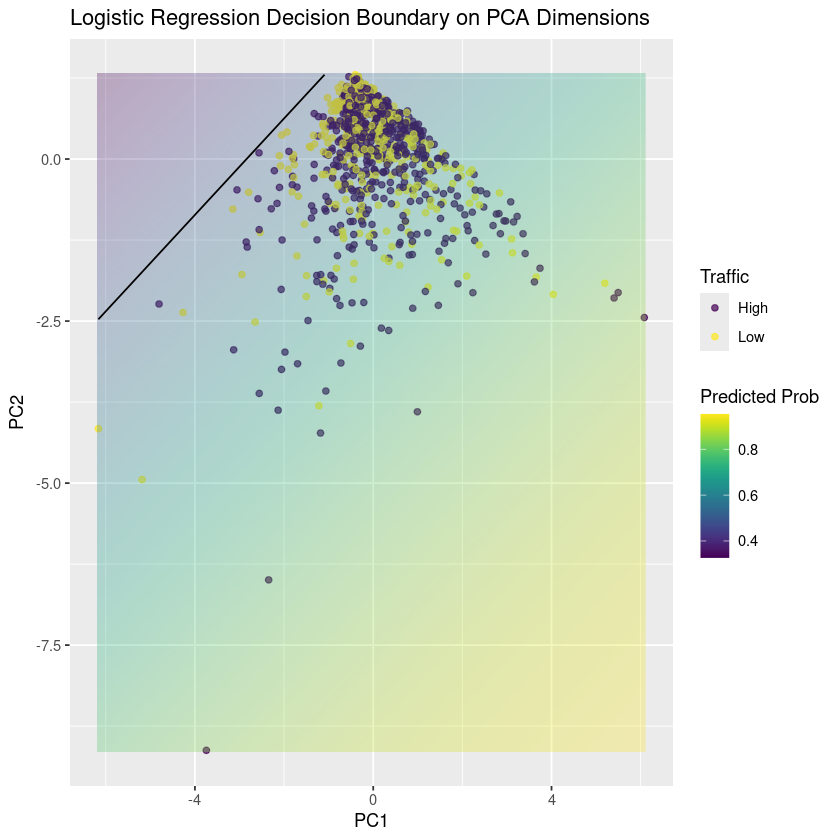

In [24]:
require(tidyverse)
require(tidymodels)
require(viridis)


traffic_pca <- traffic_clean |>
  select(where(is.numeric)) |>
  prcomp(scale. = TRUE)
scores <- as_tibble(traffic_pca$x) |>
  mutate(high_traffic = traffic_clean$high_traffic)
log_reg <- logistic_reg() |>
  set_mode("classification") |>
  set_engine("glm")
log_reg_fit <- log_reg |>
  fit(high_traffic ~ PC1 + PC2, data = scores)
grid <- expand.grid(
  PC1 = seq(min(scores$PC1), max(scores$PC1), length.out = 200),
  PC2 = seq(min(scores$PC2), max(scores$PC2), length.out = 200)
)
grid$prob <- predict(log_reg_fit, new_data = grid, type = "prob")[[".pred_High"]]

ggplot(scores, aes(x = PC1, y = PC2, colour = high_traffic)) +
  geom_point(alpha = 0.7) +
  geom_raster(data = grid, aes(x = PC1, y = PC2, fill = prob), alpha = 0.3, inherit.aes = FALSE) +
  geom_contour(data = grid, aes(x = PC1, y = PC2, z = prob), breaks = 0.5, colour = "black") +
  scale_colour_viridis_d(option = "D") +
  scale_fill_viridis(option = "D", name = "Predicted Prob") +
  labs(
    title = "Logistic Regression Decision Boundary on PCA Dimensions",
    x = "PC1",
    y = "PC2",
    colour = "Traffic"
  )

rm(traffic_pca, scores, log_reg, log_reg_fit, grid)

The plot shows the logistic regression decision boundary overlaid on the first two principal components of the dataset. The black contour line represents the threshold where the predicted probability of “High” traffic equals 0.5. The background shading illustrates the probability gradient, with lighter areas indicating higher predicted probabilities and darker areas indicating lower probabilities.

Most observations cluster near the top of the plot, and the decision boundary cuts diagonally across this dense region. The fact that nearly all points lie on one side of the boundary suggests that the first two principal components do not strongly separate the classes, and the model relies on a subtle linear trend rather than a clear division.

This visualisation reinforces that logistic regression is well suited for problems with primarily linear relationships, but it also highlights the limited discriminative power of the first two components in this case.

## Quantitative

I reviewed the full results table to compare and contrast all models using the two key classification metrics.

In [25]:
metrics_table

Model Name,Accuracy,ROC AUC
<chr>,<dbl>,<dbl>
Logistic Regression,0.76,0.84
Regularised Logistic Regression,0.76,0.84
Random Forest,0.76,0.83
k-Nearest Neighbours,0.73,0.82
MLP,0.75,0.81
Tuned Tree,0.70,0.79
Decision Tree,0.76,0.77
Null Model,0.60,0.50


The evaluation table shows that logistic regression, regularised logistic regression, and random forest achieved the highest accuracy scores at 0.76, with ROC AUC values of 0.84, 0.84, and 0.83 respectively. These results indicate that simpler models performed as well as more complex approaches, reinforcing the principle of parsimony. The decision tree and tuned tree lagged behind, with accuracies of 0.76 and 0.70 and ROC AUC values of 0.77 and 0.79, suggesting limited benefit from tuning in this case. The k-nearest neighbours model reached 0.73 accuracy and 0.82 ROC AUC, while the multilayer perceptron achieved 0.75 accuracy and 0.81 ROC AUC, showing that non-parametric and neural network methods did not outperform the simpler alternatives. The null model, with 0.60 accuracy and 0.50 ROC AUC, provided a baseline that all other models exceeded. Overall, these results suggest that regularised logistic regression offers a strong balance of interpretability and predictive performance, making it a practical choice for this problem.

## Final Fit

With the qualitative and quantitative evalautions complete, it was clear that the simple logistic regression was the most efficient. I selected this as the best model of those tested, and moved onto conducting a final fit on the hitherto held-out validation set.

Model Name,Accuracy,ROC AUC
<chr>,<dbl>,<dbl>
Logistic Regression,0.76,0.84
Regularised Logistic Regression,0.76,0.84
Random Forest,0.76,0.83
k-Nearest Neighbours,0.73,0.82
MLP,0.75,0.81
Logistic Regression (Final),0.75,0.81
Tuned Tree,0.70,0.79
Decision Tree,0.76,0.77
Null Model,0.60,0.50


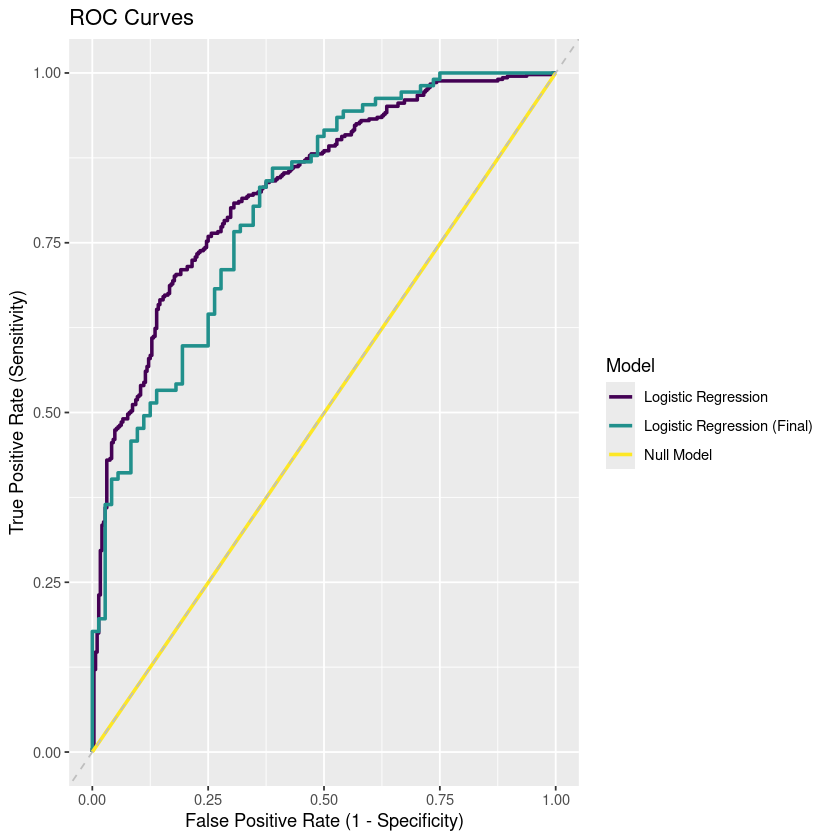

In [26]:
require(tidyverse)
require(tidymodels)

final_fit <- fit(workflow_2_logistic, data = training)

final_preds <- predict(final_fit, new_data = validation, type = "prob") |>
    bind_cols(predict(final_fit, new_data = validation, type = "class")) |>
    bind_cols(validation |> select(high_traffic))
final_accuracy <- final_preds |> accuracy(truth = high_traffic, estimate = .pred_class) |> pull(.estimate)
final_roc_auc  <- final_preds |> roc_auc(truth = high_traffic, .pred_High) |> pull(.estimate)


metrics_table <- metrics_table |>
    filter(`Model Name` != "Logistic Regression (Final)") |>
       bind_rows(
        tibble(
            `Model Name` = "Logistic Regression (Final)",
            Accuracy = round(final_accuracy, 2),
            `ROC AUC` = round(final_roc_auc, 2)
        )
    ) |>
    arrange(desc(`ROC AUC`))
metrics_table


roc_data_all <- map2_dfr(
    list(
        result_1_null,
        result_2_logistic
    ),
    c(
        "Null Model",
        "Logistic Regression"
    ),
    ~ collect_predictions(.x) |>
        roc_curve(truth = high_traffic, .pred_High) |>
        mutate(Model = .y)
) |>
    bind_rows(
        final_preds |>
            roc_curve(truth = high_traffic, .pred_High) |>
            mutate(Model = "Logistic Regression (Final)")
)

roc_data_all |>
    ggplot(aes(x = 1 - specificity, y = sensitivity, color = Model)) +
    geom_path(linewidth = 1) +
    geom_abline(lty = 2, color = "gray") +
       scale_color_viridis_d(option = "D") +
    labs(
        title = "ROC Curves",
        x = "False Positive Rate (1 - Specificity)",
        y = "True Positive Rate (Sensitivity)",
        color = "Model")


I analysed the ROC curve and the metrics table and saw that the logistic regression model performed better during cross-validation than when I fitted it to the training set and evaluated it on the validation set. The cross-validated model achieved a ROC AUC of 0.84 and an accuracy of 0.76, while the final fit dropped to a ROC AUC of 0.81 and an accuracy of 0.75.

The validation set had the same class distribution as the training set, so imbalance was not the cause. The difference likely came from sampling variability and the fact that cross-validation averages performance across folds, which smooths out harder cases. The final fit faced a single unseen partition, which may have contained patterns that were not well captured during training. This showed that the cross-validation estimate was slightly optimistic and reinforced why I used a separate validation set to check generalisation.

Ultimately this reinforced the importance of a final holdout validation set to measure, as much as possible within the given data, the real-world efficacy of the models I developed.

In [31]:
require(tidyverse)
require(tidymodels)

final_fit |>
    tidy() |>
    filter(
		is.finite(p.value),
		p.value <= 0.55) |>
	arrange(p.value)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
category_Beverages,0.95772937,0.1724638,5.5532197,2.804553e-08
(Intercept),-0.67521128,0.1352015,-4.9941115,5.910724e-07
category_Potato,-0.79746252,0.1956317,-4.0763455,4.574903e-05
category_Pork,-0.58445541,0.1615397,-3.6180288,2.968554e-04
category_Vegetable,-1.04623769,0.2934834,-3.5648957,3.640009e-04
category_Breakfast,0.42240106,0.1259000,3.3550518,7.935014e-04
category_One.Dish.Meal,-0.27911119,0.1278984,-2.1822878,2.908830e-02
servings_X1,-0.25438608,0.1209096,-2.1039366,3.538398e-02
category_Chicken,0.23786482,0.1223847,1.9435825,5.194581e-02


The logistic regression coefficients above indicate how each predictor influences the likelihood of high traffic to the recipe website.

Positive coefficients, such as for Beverages `0.96` and Breakfast `0.42`, suggest these categories significantly increase the probability of attracting visitors. In contrast, negative coefficients, including Vegetable `-1.05` and Potato ``-0.80), indicate these recipes are less likely to drive traffic. The magnitude of the coefficient reflects the strength of the effect, while the p-values confirm statistical significance. Categories with very low p-values, such as Beverages and Vegetable, provide strong evidence of their impact on traffic, whereas predictors like calories and sugar show no meaningful influence.

### Strong Predictors

| Predictor                  | Estimate  | p-value      | Interpretation                |
|---------------------------|-----------|-------------|--------------------------------|
| Beverages        | 0.9577    | 2.8046e-8   | Strong positive effect        |
| Vegetable        | -1.0462   | 0.0004      | Strong negative effect        |
| Potato           | -0.7975   | 0           | Strong negative effect        |
| Pork             | -0.5845   | 0.0003      | Moderate negative effect               |
| Breakfast        | 0.4224    | 0.0008      | Moderate positive effect               |

### Moderate Predictors

| Predictor                  | Estimate  | p-value      | Interpretation                |
|---------------------------|-----------|-------------|--------------------------------|
| One.Dish.Meal    | -0.2791   | 0.0291      | Slight negative effect        |
| servings_X1               | -0.2544   | 0.0354      | Slight negative effect        |

### Poor Predictors
| Predictor                  | Estimate  | p-value      | Interpretation                |
|---------------------------|-----------|-------------|--------------------------------|
| Chicken          | 0.2379    | 0.0519      | Borderline positive           |
| Meat             | -0.2183   | 0.0916      | Weak negative                 |
| Chicken.Breast   | 0.1754    | 0.1728      | No meaningful effect          |
| Lunch.Snacks              | -0.0767   | 0.5087      | Negligible effect             |
| calories                  | 0.044     | 0.6593      | Negligible effect             |



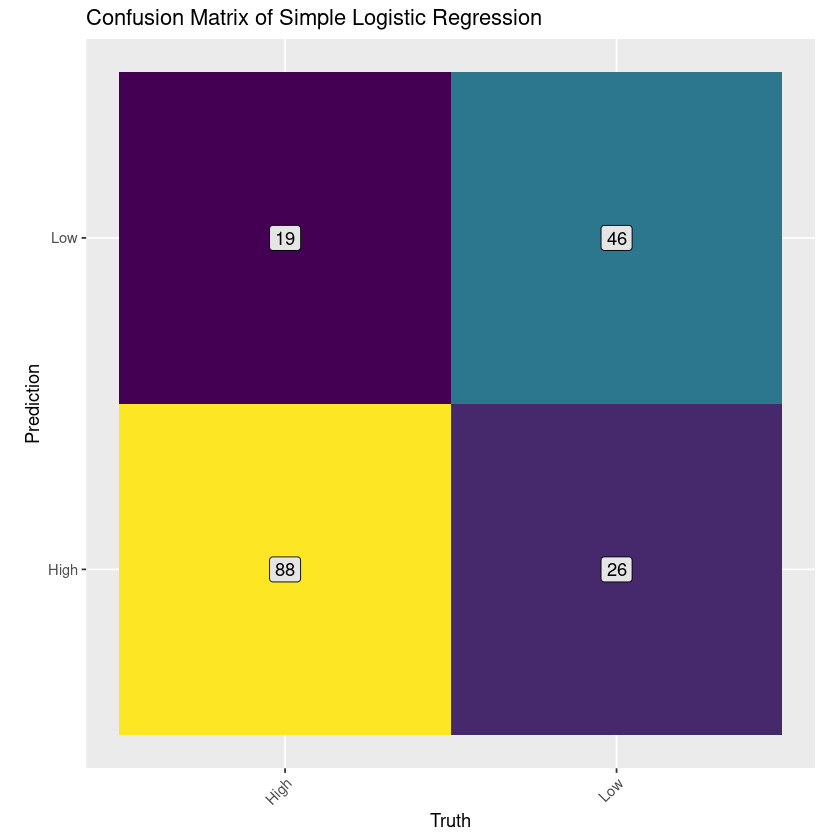

In [28]:
require(tidyverse)
require(tidymodels)
require(viridis)

conf_data <- final_preds |>
  count(Truth = high_traffic, Prediction = .pred_class)

ggplot(conf_data, aes(x = Truth, y = Prediction, fill = n)) +
  geom_tile() +
  geom_label(aes(label = n), fill = "grey90", color = "black") +
  scale_fill_viridis_c() +
  labs(title = "Confusion Matrix of Simple Logistic Regression") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "none") +
  coord_fixed()

The confusion matrix for the final logistic regression model shows 88 true positives (correctly predicted high traffic) and 19 true negatives (correctly predicted low traffic). However, the model also produced 46 false negatives (actual high traffic predicted as low) and 26 false positives (actual low traffic predicted as high). This indicates the model is better at identifying high-traffic recipes than low-traffic ones, but it still misses a substantial number of high-traffic cases. The imbalance between false negatives and true positives suggests sensitivity could be improved. Overall, the model demonstrates reasonable predictive power but may require further tuning or additional features to reduce misclassification, particularly for high-traffic recipes.

# Business Metrics

To evaluate modelling in terms of business impact, I defined metrics that align with the primary goal: increasing traffic to the recipe website. The dataset showed that 60% of recipes produced high traffic, so a random selection would achieve 60% accuracy. The question for the business was two-fold: did the modelling improve the ability to select recipes that generate high traffic, and if so, by how much?

Compared to random choice, which has a 60% hit rate selecting a recipe producing high traffic, my best model, the logistic regression, had a 75% hit rate, a 75% improvement over baseline. This is a meaningful increase and strongly favours implementing the model to increase site traffic.

The model achieved this result by analysing the correlation between all the different attributes, and a recipe resulting in high traffic. Overall, the recipe category was the strongest predictor of high traffic recipes. The categories of Beverages and Breakfast correlated to high traffic. In contrast, the categories of Vegetable, Potato, and Pork correlated to low traffic. Factors such as the number of calories in particular, as well as other macronutrient measurements, did not have any significant impact on whether a website produce high traffic.

A logistic regression is the simplest and most explainable model for classification. It works a lot like drawing a straight line through data in linear regression, except instead of predicting a number, it predicts the probability of something happening, like whether a recipe will get high traffic. It uses that line to separate the data into two groups and is easy to understand because each factor just pushes the probability up or down.


| Model            | Accuracy | ROC-AUC |
|------------------|----------|---------|
| Null (Random)    | 0.60     | 0.50    |
| Logistic Model   | 0.75     | 0.81    |


# Summary

I undertook an end-to-end analysis for Tasty Bytes to predict which homepage recipes would generate high website traffic. I began by setting up the environment and importing the dataset. I validated and cleaned the data by removing missing numeric values, converting categorical variables to factors, and parsing servings into a nominal factor. I inferred missing values in the outcome variable high_traffic as low traffic and converted it to a factor. I treated missing values in calories, carbohydrates, sugar, and protein by removing affected rows. I converted category and servings to factors, cleaned servings by removing non-numeric characters, and inferred missing high_traffic values as low traffic.

I explored the data to understand its structure and distribution. Categorical variables were mostly balanced, except for a 60:40 skew in high_traffic and a slight skew in servings. Numeric predictors showed heavy right skew, which I addressed using a Yeo-Johnson transformation after detecting zero values. I performed Principal Component Analysis to summarise variance and guide feature selection. Correlation checks confirmed no significant multicollinearity. I included visualisations of single-variable distributions including histograms for numeric variables, pie charts for categorical variables, and a correlation plot, and a correlation plot to illustrate relationships between predictors.

I engineered the data by splitting it into training, testing, and validation sets, applying 10-fold cross-validation to the training set. I created a preprocessing pipeline that applied one-hot encoding, normalisation, and removal of zero-variance predictors.

I established a null model as a baseline, which achieved 60% accuracy and a ROC AUC of 0.50. This null moodel would form a baseline instead of the arbitrary coin flip. I then developed and compared several models, including logistic regression, regularised logistic regression, decision trees, tuned trees, random forest, k-nearest neighbours, and a neural network. Logistic regression and its regularised variant achieved the best performance, with accuracy of 0.76 and ROC AUC of 0.84 during cross-validation. Random forest performed similarly, while tuned trees and KNN delivered modest gains. Neural network tuning revealed minimal benefit, indicating limited non-linear patterns. It was clear that given the dataset size and number of predictors, more complicated models did not give significant performance benefits.

I evaluated models using accuracy, ROC AUC, and ROC curves. Simpler models matched or exceeded complex alternatives, reinforcing the principle of parsimony. The final logistic regression fit on the validation set achieved 0.75 accuracy and 0.81 ROC AUC, slightly lower than cross-validation estimates due to sampling variability.

I defined business success as improving recipe selection accuracy beyond the 60% baseline from random choice. I assessed business impact by comparing model performance to random selection. The logistic regression model improved recipe selection accuracy from 60% to 75%, which was a 15% improvement. Category was the strongest predictor, with Beverages and Breakfast increasing traffic likelihood, while Vegetable, Potato, and Pork reduced it. Macronutrient values had negligible effect.

I recommend implementing logistic regression due to its interpretability, efficiency, and strong predictive performance. I also recommend reducing false negatives through tuning, which the data indicates could improve performance without reducing interpretability.